In [1]:
import os
import numpy as np
from tqdm.auto import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch
import torch.nn as nn
import torch.onnx
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from PIL import Image
from torchinfo import summary

import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.callbacks import LearningRateMonitor

In [2]:
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE: ", DEVICE)
BATCH_SIZE = 32 # 64 in original paper but resource exhausted error otherwise.
WEIGHT_DECAY = 0
EPOCHS = 50

DEVICE:  cpu


# Dataset

In [3]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes


transform = Compose([transforms.Resize((88, 88)), transforms.ToTensor()])

In [4]:


class DiorDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, S=4, B=2, C=1, transform=None, train=True):
        self.root_dir = root_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C
        self.train = train

       # Determine the directory of the images and labels
        if self.train:
            self.img_dir = os.path.join(self.root_dir, 'images/train')
            self.label_dir = os.path.join(self.root_dir, 'labels/train')
        else:
            self.img_dir = os.path.join(self.root_dir, 'images/test')
            self.label_dir = os.path.join(self.root_dir, 'labels/test')

        self.img_ids = os.listdir(self.img_dir)

    def __len__(self):
        return len(self.img_ids)

    def __getitem__(self, index):
        img_id = self.img_ids[index].split('.')[0]
        boxes = []

        # Load image
        img_path = os.path.join(self.img_dir, img_id + '.jpg')
        image = Image.open(img_path)
        image = image.convert("L")

        # Load labels
        label_path = os.path.join(self.label_dir, img_id + '.txt')
        with open(label_path, 'r') as f:
            for line in f.readlines():
                class_label, x, y, width, height = map(float, line.strip().split())
                boxes.append([class_label, x, y, width, height])
        
        if len(boxes) > 3:
            boxes = boxes[:3]
        boxes = torch.tensor(boxes)
        #print(f"boxes: {boxes}")
        if self.transform:
            image, boxes = self.transform(image, boxes)

        # Convert To Cells
        label_matrix = torch.zeros((self.S, self.S, self.C + 5 * self.B))
        for box in boxes:
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label)

            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i

            width_cell, height_cell = (
                width * self.S,
                height * self.S,
            )

            if label_matrix[i, j, self.C] == 0:
                label_matrix[i, j, self.C] = 1

                box_coordinates = torch.tensor(
                    [x_cell, y_cell, width_cell, height_cell]
                )

                label_matrix[i, j, self.C+1:self.C+5] = box_coordinates
                label_matrix[i, j, class_label] = 1
    
        #print(f"label_matrix shape: {label_matrix.shape}")

        return image, label_matrix

In [5]:
from torch.utils.data import random_split

files_dir = '/home/buono/ObjDct_Repo/data/ShipDataset'

train_dataset = DiorDataset(
    root_dir=files_dir,
    transform=transform,
    train=True
)


# Define the length of the training set and validation set
train_len = int(0.8 * len(train_dataset))
val_len = len(train_dataset) - train_len

# Split the dataset
train_dataset, validation_dataset = random_split(train_dataset, [train_len, val_len])


# Now you can create your DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)
val_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)


In [6]:
test_dataset = DiorDataset(
    root_dir=files_dir,
    transform=transform,
    train=False
)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)

In [7]:
len(train_dataset), len(validation_dataset), len(test_dataset)

(25426, 6357, 7946)

# Utility Function

In [8]:
def intersection_over_union(boxes_preds, boxes_labels):
    """
    Calculates intersection over union
    
    Parameters:
        boxes_preds (tensor): Predictions of Bounding Boxes (BATCH_SIZE, 4)
        boxes_labels (tensor): Correct labels of Bounding Boxes (BATCH_SIZE, 4)    
    Returns:
        tensor: Intersection over union for all examples
    """
    # boxes_preds shape is (N, 4) where N is the number of bboxes
    #boxes_labels shape is (n, 4)
    
    box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
    box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
    box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
    box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
    box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
    box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
    box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
    box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2
    
    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)
    #print(f"x1: {x1}, y1: {y1}, x2: {x2}, y2: {y2}")
    
    #.clamp(0) is for the case when they don't intersect. Since when they don't intersect, one of these will be negative so that should become 0
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    #print(f"intersection: {intersection}")

    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))
    #print(f"box1_area: {box1_area}, box2_area: {box2_area}")
    
    return intersection / (box1_area + box2_area - intersection + 1e-6)

In [9]:
def non_max_suppression(bboxes, iou_threshold, threshold):
    """
    Does Non Max Suppression given bboxes
    Parameters:
        bboxes (list): list of lists containing all bboxes with each bboxes
        specified as [class_pred, prob_score, x_center, y_center, width, height]
        iou_threshold (float): threshold where predicted bboxes is correct
        threshold (float): threshold to remove predicted bboxes (independent of IoU) 
    Returns:
        list: bboxes after performing NMS given a specific IoU threshold
    """

    assert type(bboxes) == list

    bboxes = [box for box in bboxes if box[1] > threshold]
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)
    bboxes_after_nms = []

    while bboxes:
        chosen_box = bboxes.pop(0)
        bboxes_after_nms.append(chosen_box)
        break
    #print(f"bboxes_after_nms: {bboxes_after_nms}")

    return bboxes_after_nms

In [10]:
def mean_average_precision(
    pred_boxes, true_boxes, iou_threshold=0, num_classes=1
):
    """
    Calculates mean average precision 
    Parameters:
        pred_boxes (list): list of lists containing all bboxes with each bboxes
        specified as [train_idx, class_prediction, prob_score, x_center, y_center, width, height]
        true_boxes (list): Similar as pred_boxes except all the correct ones 
        iou_threshold (float): threshold where predicted bboxes is correct
        num_classes (int): number of classes
    Returns:
        float: mAP value across all classes given a specific IoU threshold 
    """

    # list storing all AP for respective classes
    average_precisions = []

    # used for numerical stability later on
    epsilon = 1e-6

    for c in range(num_classes):
        detections = []
        ground_truths = []

        # Go through all predictions and targets,
        # and only add the ones that belong to the
        # current class c
        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)
        #print(f"{c} class has {len(detections)} detections")

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)
        #print(f"{c} class has {len(ground_truths)} ground truths")

        # find the amount of bboxes for each training example
        # Counter here finds how many ground truth bboxes we get
        # for each training example, so let's say img 0 has 3,
        # img 1 has 5 then we will obtain a dictionary with:
        # amount_bboxes = {0:3, 1:5}
        amount_bboxes = Counter([gt[0] for gt in ground_truths])
        #print(f"{c} class has {len(amount_bboxes)} amount bboxes")

        # We then go through each key, val in this dictionary
        # and convert to the following (w.r.t same example):
        # ammount_bboxes = {0:torch.tensor[0,0,0], 1:torch.tensor[0,0,0,0,0]}
        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        # sort by box probabilities which is index 2
        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)
        #print(f"{c} class has {total_true_bboxes} total true bboxes")
        # If none exists for this class then we can safely skip
        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):
            # Only take out the ground_truths that have the same
            # training idx as detection
            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            #print(f"{c} class has {num_gts} ground truths for detection {detection_idx}")
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:])
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:
                # only detect ground truth detection once
                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    # true positive and add this bounding box to seen
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    #These additional detections are considered false positives because they do not correspond to a new, unique object
                    #they're essentially "over-detecting" an object that has already been correctly identified.
                    FP[detection_idx] = 1

            # if IOU is lower then the detection is a false positive
            else:
                FP[detection_idx] = 1

        #[1, 1, 0, 1, 0] -> [1, 2, 2, 3, 3]
        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        # torch.trapz for numerical integration
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

In [11]:
def get_bboxes(
    loader,
    model,
    iou_threshold=0,
    threshold=0,
    device="cpu",
):
    all_pred_boxes = []
    all_true_boxes = []

    # make sure model is in eval before get bboxes
    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold,
            )

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                # many will get converted to 0 pred
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()
    return all_pred_boxes, all_true_boxes


In [12]:
def convert_cellboxes(predictions, S=4, C=1):
    """
    Converts bounding boxes output from Yolo with
    an image split size of S into entire image ratios
    rather than relative to cell ratios.
    """
    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, S, S, C + 10)
    bboxes1 = predictions[..., C + 1:C + 5]
    bboxes2 = predictions[..., C + 6:C + 10]
    
    scores = torch.cat(
        (predictions[..., C].unsqueeze(0), predictions[..., C + 5].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    # This results in a tensor with shape (batch_size, 7, 7, 1) where each element represents the index of a grid cell.
    cell_indices = torch.arange(S).repeat(batch_size, S, 1).unsqueeze(-1)

    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    # Permute because is used here to swap these indices to match the (x, y) convention used in the best_boxes tensor.
    # [0,1,2]->[0,0,0]
    # [0,1,2]->[1,1,1]
    # [0,1,2]->[2,2,2]
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]

    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :C].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., C], predictions[..., C + 5]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )
    #print(f"converted_preds: {converted_preds}")

    return converted_preds

In [13]:
def cellboxes_to_boxes(out, S=4):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    #iterate over each batch sample
    for ex_idx in range(out.shape[0]):
        bboxes = []
        #iterate over each grid in the grid cell
        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)
    #print(f"all_bboxes: {all_bboxes}")
    return all_bboxes

In [14]:
class YoloLoss(nn.Module):
    """
    Calculate the loss for yolo (v1) model
    """

    def __init__(self, S=4, B=2, C=1):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        """
        S is split size of image (in paper 7),
        B is number of boxes (in paper 2),
        C is number of classes (in paper 20, in dataset 3),
        """
        self.S = S
        self.B = B
        self.C = C

        # These are from Yolo paper, signifying how much we should
        # pay loss for no object (noobj) and the box coordinates (coord)
        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # predictions are shaped (BATCH_SIZE, S*S(C+B*5) when inputted
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5)

        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou_b1 = intersection_over_union(predictions[..., self.C + 1:self.C + 5], target[..., self.C + 1:self.C + 5])
        iou_b2 = intersection_over_union(predictions[..., self.C + 6:self.C + 10], target[..., self.C + 1:self.C + 5])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        # Take the box with highest IoU out of the two prediction
        # Note that bestbox will be indices of 0, 1 for which bbox was best
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., self.C].unsqueeze(3)  # in paper this is Iobj_i

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #

        # Set boxes with no object in them to 0. We only take out one of the two 
        # predictions, which is the one with highest Iou calculated previously.
        box_predictions = exists_box * (
            (
                bestbox * predictions[..., self.C + 6:self.C + 10]
                + (1 - bestbox) * predictions[..., self.C + 1:self.C + 5]
            )
        )
        #print(f"box_predictions: {box_predictions.shape}")
        box_targets = exists_box * target[..., self.C + 1:self.C + 5]

        # Take sqrt of width, height of boxes
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #

        # pred_box is the confidence score for the bbox with highest IoU
        pred_box = (
            bestbox * predictions[..., self.C + 5:self.C + 6] + (1 - bestbox) * predictions[..., self.C:self.C + 1]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., self.C:self.C + 1]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #

        #max_no_obj = torch.max(predictions[..., 20:21], predictions[..., 25:26])
        #no_object_loss = self.mse(
        #    torch.flatten((1 - exists_box) * max_no_obj, start_dim=1),
        #    torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        #)

        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., self.C:self.C + 1], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., self.C:self.C + 1], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., self.C + 5:self.C + 6], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., self.C:self.C + 1], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #

        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :self.C], end_dim=-2,),
            torch.flatten(exists_box * target[..., :self.C], end_dim=-2,),
        )

        loss = (
            self.lambda_coord * box_loss  # first two rows in paper
            + object_loss  # third row in paper
            + self.lambda_noobj * no_object_loss  # forth row
            + class_loss  # fifth row
        )

        return loss

# Models

## Tinyissimo YOLO

In [15]:
class LinearActivation(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, t):
        return torch.pow(t, 1)

In [16]:
class TinyissimoYOLO(L.LightningModule):
    def __init__(self, B=2, num_classes=1, S=4):
        super().__init__()

        self.loss_fn = YoloLoss()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            LinearActivation(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            LinearActivation(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            LinearActivation(),
            nn.AvgPool2d(kernel_size=2,stride = 2)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            LinearActivation(),
            nn.AvgPool2d(kernel_size=2,stride = 2)
        )

        self.fclayers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*5*5, 256),
            LinearActivation(),
            nn.Linear(256, S*S*(num_classes + 5*B)),
        )


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.fclayers(x)
        
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        loss = self.loss_fn(out, y)
        self.log('train_loss', loss)
        return loss
    
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        loss = self.loss_fn(out, y)
        self.log('val_loss', loss)
        return loss
        

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)



model = TinyissimoYOLO()
summary(model, input_size=(1, 1, 88, 88))

Layer (type:depth-idx)                   Output Shape              Param #
TinyissimoYOLO                           [1, 176]                  --
├─Sequential: 1-1                        [1, 16, 44, 44]           --
│    └─Conv2d: 2-1                       [1, 16, 88, 88]           160
│    └─LinearActivation: 2-2             [1, 16, 88, 88]           --
│    └─AvgPool2d: 2-3                    [1, 16, 44, 44]           --
├─Sequential: 1-2                        [1, 32, 22, 22]           --
│    └─Conv2d: 2-4                       [1, 32, 44, 44]           4,640
│    └─LinearActivation: 2-5             [1, 32, 44, 44]           --
│    └─AvgPool2d: 2-6                    [1, 32, 22, 22]           --
├─Sequential: 1-3                        [1, 64, 11, 11]           --
│    └─Conv2d: 2-7                       [1, 64, 22, 22]           18,496
│    └─LinearActivation: 2-8             [1, 64, 22, 22]           --
│    └─AvgPool2d: 2-9                    [1, 64, 11, 11]           --
├─Seque

In [17]:
# loss_fn = YoloLoss()

# checkpoint_callback = ModelCheckpoint(save_top_k=1, 
#                                       monitor="val_loss", 
#                                       mode="min")
# lr_monitor_callback = LearningRateMonitor(logging_interval='epoch')

# trainer = L.Trainer(accelerator=DEVICE, 
#                     callbacks=[checkpoint_callback, lr_monitor_callback], 
#                     max_epochs=EPOCHS, 
#                     enable_progress_bar=True, 
#                     enable_model_summary=True)

# os.makedirs("lightning_logs", exist_ok=True)

# trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

In [18]:
# torch.save(model.state_dict(), "../../models/trained_models/TinyissimoYOLO.pth")

## Different number of filters

In [19]:
class TinyissimoYOLOv1(L.LightningModule):
    def __init__(self, B=2, num_classes=1, S=4):
        super().__init__()

        self.loss_fn = YoloLoss()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 12, kernel_size=3, stride=1, padding=1),
            LinearActivation(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(12, 24, kernel_size=3, stride=1, padding=1),
            LinearActivation(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(24, 48, kernel_size=3, stride=1, padding=1),
            LinearActivation(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(48, 96, kernel_size=3, stride=1, padding=1),
            LinearActivation(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.fclayers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(96*5*5, 256),
            LinearActivation(),
            nn.Linear(256, S*S*(num_classes + 5*B)),
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.fclayers(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        loss = self.loss_fn(out, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        loss = self.loss_fn(out, y)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

model = TinyissimoYOLOv1()
summary(model, input_size=(1, 1, 88, 88))

Layer (type:depth-idx)                   Output Shape              Param #
TinyissimoYOLOv1                         [1, 176]                  --
├─Sequential: 1-1                        [1, 12, 44, 44]           --
│    └─Conv2d: 2-1                       [1, 12, 88, 88]           120
│    └─LinearActivation: 2-2             [1, 12, 88, 88]           --
│    └─AvgPool2d: 2-3                    [1, 12, 44, 44]           --
├─Sequential: 1-2                        [1, 24, 22, 22]           --
│    └─Conv2d: 2-4                       [1, 24, 44, 44]           2,616
│    └─LinearActivation: 2-5             [1, 24, 44, 44]           --
│    └─AvgPool2d: 2-6                    [1, 24, 22, 22]           --
├─Sequential: 1-3                        [1, 48, 11, 11]           --
│    └─Conv2d: 2-7                       [1, 48, 22, 22]           10,416
│    └─LinearActivation: 2-8             [1, 48, 22, 22]           --
│    └─AvgPool2d: 2-9                    [1, 48, 11, 11]           --
├─Seque

In [20]:
# loss_fn = YoloLoss()

# checkpoint_callback = ModelCheckpoint(save_top_k=1, 
#                                       monitor="val_loss", 
#                                       mode="min")
# lr_monitor_callback = LearningRateMonitor(logging_interval='epoch')

# trainer = L.Trainer(accelerator=DEVICE, 
#                     callbacks=[checkpoint_callback, lr_monitor_callback], 
#                     max_epochs=EPOCHS, 
#                     enable_progress_bar=True, 
#                     enable_model_summary=True)

# os.makedirs("lightning_logs", exist_ok=True)

# trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

In [21]:
# torch.save(model.state_dict(), "../../models/trained_models/TinyissimoYOLOv1.pth")

## Add a convolution level

In [22]:
class TinyissimoYOLOv2(L.LightningModule):
    def __init__(self, B=2, num_classes=1, S=4):
        super().__init__()

        self.loss_fn = YoloLoss()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            LinearActivation(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            LinearActivation(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            LinearActivation(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            LinearActivation(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            LinearActivation(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.fclayers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256*2*2, 512),
            LinearActivation(),
            nn.Linear(512, S*S*(num_classes + 5*B)),
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.fclayers(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        loss = self.loss_fn(out, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        loss = self.loss_fn(out, y)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)

model = TinyissimoYOLOv2()
summary(model, input_size=(1, 1, 88, 88))

Layer (type:depth-idx)                   Output Shape              Param #
TinyissimoYOLOv2                         [1, 176]                  --
├─Sequential: 1-1                        [1, 16, 44, 44]           --
│    └─Conv2d: 2-1                       [1, 16, 88, 88]           160
│    └─LinearActivation: 2-2             [1, 16, 88, 88]           --
│    └─AvgPool2d: 2-3                    [1, 16, 44, 44]           --
├─Sequential: 1-2                        [1, 32, 22, 22]           --
│    └─Conv2d: 2-4                       [1, 32, 44, 44]           4,640
│    └─LinearActivation: 2-5             [1, 32, 44, 44]           --
│    └─AvgPool2d: 2-6                    [1, 32, 22, 22]           --
├─Sequential: 1-3                        [1, 64, 11, 11]           --
│    └─Conv2d: 2-7                       [1, 64, 22, 22]           18,496
│    └─LinearActivation: 2-8             [1, 64, 22, 22]           --
│    └─AvgPool2d: 2-9                    [1, 64, 11, 11]           --
├─Seque

In [23]:
# loss_fn = YoloLoss()

# checkpoint_callback = ModelCheckpoint(save_top_k=1, 
#                                       monitor="val_loss", 
#                                       mode="min")
# lr_monitor_callback = LearningRateMonitor(logging_interval='epoch')

# trainer = L.Trainer(accelerator=DEVICE, 
#                     callbacks=[checkpoint_callback, lr_monitor_callback], 
#                     max_epochs=EPOCHS, 
#                     enable_progress_bar=True, 
#                     enable_model_summary=True)

# os.makedirs("lightning_logs", exist_ok=True)

# trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

In [24]:
# torch.save(model.state_dict(), "../../models/trained_models/TinyissimoYOLOv2.pth")

## Different kernel size and padding

In [25]:
class TinyissimoYOLOv3(L.LightningModule):
    def __init__(self, B=2, num_classes=1, S=4):
        super().__init__()

        self.loss_fn = YoloLoss()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            LinearActivation(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            LinearActivation(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            LinearActivation(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=5, stride=1, padding=2),
            LinearActivation(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fclayers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*5*5, 256),
            LinearActivation(),
            nn.Linear(256, S*S*(num_classes + 5*B)),
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.fclayers(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        loss = self.loss_fn(out, y)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        loss = self.loss_fn(out, y)
        self.log('val_loss', loss)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    
model = TinyissimoYOLOv3()
summary(model, input_size=(1, 1, 88, 88))


Layer (type:depth-idx)                   Output Shape              Param #
TinyissimoYOLOv3                         [1, 176]                  --
├─Sequential: 1-1                        [1, 16, 44, 44]           --
│    └─Conv2d: 2-1                       [1, 16, 88, 88]           416
│    └─LinearActivation: 2-2             [1, 16, 88, 88]           --
│    └─MaxPool2d: 2-3                    [1, 16, 44, 44]           --
├─Sequential: 1-2                        [1, 32, 22, 22]           --
│    └─Conv2d: 2-4                       [1, 32, 44, 44]           12,832
│    └─LinearActivation: 2-5             [1, 32, 44, 44]           --
│    └─MaxPool2d: 2-6                    [1, 32, 22, 22]           --
├─Sequential: 1-3                        [1, 64, 11, 11]           --
│    └─Conv2d: 2-7                       [1, 64, 22, 22]           51,264
│    └─LinearActivation: 2-8             [1, 64, 22, 22]           --
│    └─MaxPool2d: 2-9                    [1, 64, 11, 11]           --
├─Sequ

In [26]:
# loss_fn = YoloLoss()

# checkpoint_callback = ModelCheckpoint(save_top_k=1, 
#                                       monitor="val_loss", 
#                                       mode="min")
# lr_monitor_callback = LearningRateMonitor(logging_interval='epoch')

# trainer = L.Trainer(accelerator=DEVICE, 
#                     callbacks=[checkpoint_callback, lr_monitor_callback], 
#                     max_epochs=EPOCHS, 
#                     enable_progress_bar=True, 
#                     enable_model_summary=True)

# os.makedirs("lightning_logs", exist_ok=True)

# trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

In [27]:
# torch.save(model.state_dict(), "../../models/trained_models/TinyissimoYOLOv3.pth")

## Add Dropout

In [28]:
class TinyissimoYOLOv4(L.LightningModule):
    def __init__(self, B=2, num_classes=1, S=4):
        super().__init__()

        self.loss_fn = YoloLoss()

        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            LinearActivation(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            LinearActivation(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            LinearActivation(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            LinearActivation(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )

        self.fclayers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128*5*5, 256),
            LinearActivation(),
            nn.Dropout(p=0.5),
            nn.Linear(256, S*S*(num_classes + 5*B)),
        )
    
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.fclayers(x)
        return x
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        loss = self.loss_fn(out, y)
        self.log('train_loss', loss)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        out = self(x)
        loss = self.loss_fn(out, y)
        self.log('val_loss', loss)
        return loss
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    
model = TinyissimoYOLOv4()
summary(model, input_size=(1, 1, 88, 88))


Layer (type:depth-idx)                   Output Shape              Param #
TinyissimoYOLOv4                         [1, 176]                  --
├─Sequential: 1-1                        [1, 16, 44, 44]           --
│    └─Conv2d: 2-1                       [1, 16, 88, 88]           160
│    └─LinearActivation: 2-2             [1, 16, 88, 88]           --
│    └─AvgPool2d: 2-3                    [1, 16, 44, 44]           --
├─Sequential: 1-2                        [1, 32, 22, 22]           --
│    └─Conv2d: 2-4                       [1, 32, 44, 44]           4,640
│    └─LinearActivation: 2-5             [1, 32, 44, 44]           --
│    └─AvgPool2d: 2-6                    [1, 32, 22, 22]           --
├─Sequential: 1-3                        [1, 64, 11, 11]           --
│    └─Conv2d: 2-7                       [1, 64, 22, 22]           18,496
│    └─LinearActivation: 2-8             [1, 64, 22, 22]           --
│    └─AvgPool2d: 2-9                    [1, 64, 11, 11]           --
├─Seque

In [29]:
# loss_fn = YoloLoss()

# checkpoint_callback = ModelCheckpoint(save_top_k=1, 
#                                       monitor="val_loss", 
#                                       mode="min")
# lr_monitor_callback = LearningRateMonitor(logging_interval='epoch')

# trainer = L.Trainer(accelerator=DEVICE, 
#                     callbacks=[checkpoint_callback, lr_monitor_callback], 
#                     max_epochs=EPOCHS, 
#                     enable_progress_bar=True, 
#                     enable_model_summary=True)

# os.makedirs("lightning_logs", exist_ok=True)

# trainer.fit(model=model, train_dataloaders=train_loader, val_dataloaders=val_loader)

In [30]:
# torch.save(model.state_dict(), "../../models/trained_models/TinyissimoYOLOv4.pth")

# Ensemble

# Load all models

In [31]:
models = []

model = TinyissimoYOLO()
model.load_state_dict(torch.load("../../models/trained_models/TinyissimoYOLO.pth"))
model.eval()
models.append(model)

model = TinyissimoYOLOv1()
model.load_state_dict(torch.load("../../models/trained_models/TinyissimoYOLOv1.pth"))
model.eval()
models.append(model)

model = TinyissimoYOLOv2()
model.load_state_dict(torch.load("../../models/trained_models/TinyissimoYOLOv2.pth"))
model.eval()
models.append(model)

model = TinyissimoYOLOv3()
model.load_state_dict(torch.load("../../models/trained_models/TinyissimoYOLOv3.pth"))
model.eval()
models.append(model)

model = TinyissimoYOLOv4()
model.load_state_dict(torch.load("../../models/trained_models/TinyissimoYOLOv4.pth"))
model.eval()
models.append(model)

In [32]:
pred_boxes_list = []
target_boxes_list = []
with torch.no_grad():
    pred_boxes, target_boxes = get_bboxes(
        test_loader, models[0]
    )
    pred_boxes_list.append(pred_boxes)
    target_boxes_list.append(target_boxes)
    print(f"mAP: {mean_average_precision(pred_boxes, target_boxes)}")
    
    pred_boxes, target_boxes = get_bboxes(
        test_loader, models[1]
    )
    pred_boxes_list.append(pred_boxes)
    target_boxes_list.append(target_boxes)
    print(f"mAP: {mean_average_precision(pred_boxes, target_boxes)}")

    pred_boxes, target_boxes = get_bboxes(
        test_loader, models[2]
    )
    pred_boxes_list.append(pred_boxes)
    target_boxes_list.append(target_boxes)
    print(f"mAP: {mean_average_precision(pred_boxes, target_boxes)}")

    pred_boxes, target_boxes = get_bboxes(
        test_loader, models[3]
    )
    pred_boxes_list.append(pred_boxes)
    target_boxes_list.append(target_boxes)
    print(f"mAP: {mean_average_precision(pred_boxes, target_boxes)}")

    pred_boxes, target_boxes = get_bboxes(
        test_loader, models[4]
    )
    pred_boxes_list.append(pred_boxes)
    target_boxes_list.append(target_boxes)
    print(f"mAP: {mean_average_precision(pred_boxes, target_boxes)}")
    

mAP: 0.5876208543777466
mAP: 0.6004517674446106
mAP: 0.567376434803009
mAP: 0.765967845916748
mAP: 0.6200737953186035


In [33]:
target_boxes_list = np.array(target_boxes_list)
print(f"target_boxes_list: {target_boxes_list.shape}")

target_boxes_list: (5, 9473, 7)


In [34]:
# Valori mAP per ciascun modello
mAP_values = [0.5876208543777466, 0.6004517674446106, 0.567376434803009, 0.765967845916748, 0.6200737953186035]

# Calcolo della somma dei valori mAP
sum_mAP = sum(mAP_values)

# Calcolo dei pesi normalizzati
weights = [mAP / sum_mAP for mAP in mAP_values]

print(weights)

[0.18705159775831987, 0.19113593678743163, 0.1806073897304166, 0.24382305076960895, 0.19738202495422297]


In [35]:
import numpy as np

def ensemble_center_predictions_weighted_confidence(predictions):
    """
    Ensemble predictions from multiple models by averaging center coordinates and confidence scores
    with weights based on the confidence scores of each model's predictions.

    Parameters:
        predictions (list of list of list): List of lists containing the predictions from each model.
                                            Each inner list contains vectors of shape (7,), where each
                                            vector is in the format [image_id, predicted_class, best_confidence,
                                            x_center, y_center, width, height].

    Returns:
        list of list: List of ensemble predictions with dynamically calculated weights.
    """

    def average_predictions_weighted(single_predictions):
        # Convert list of lists to numpy array
        predictions_array = np.array(single_predictions)
        
        # Extract confidence scores to calculate weights
        confidences = predictions_array[:, 2]
        weights = confidences / np.sum(confidences)
        
        # Apply weights to confidence scores and center coordinates
        weighted_confidences = np.sum(predictions_array[:, 2] * weights)
        weighted_centers = np.sum(predictions_array[:, 3:] * weights.reshape(-1, 1), axis=0)
        
        # Assuming image_id and class_ids are the same for all models, take them from the first model
        image_id = predictions_array[0, 0]
        class_id = predictions_array[0, 1]
        
        return [image_id, class_id, weighted_confidences, *weighted_centers]

    all_predictions = []
    
    # Collect all unique prediction indices across models
    max_predictions = max(len(model_predictions) for model_predictions in predictions)
    
    for i in range(max_predictions):
        single_predictions = []
        for model_predictions in predictions:
            if i < len(model_predictions):
                single_predictions.append(model_predictions[i])
        
        if single_predictions:
            ensembled_prediction = average_predictions_weighted(single_predictions)
            all_predictions.append(ensembled_prediction)
    
    return all_predictions

ensembled_predictions = ensemble_center_predictions_weighted_confidence(pred_boxes_list)
mAP = mean_average_precision(ensembled_predictions,target_boxes_list[0])
print(f"mAP: {mAP}")


mAP: 0.5852721333503723


In [36]:
# import numpy as np

# def ensemble_center_predictions_weighted(predictions):
#     """
#     Ensemble predictions from multiple models by averaging center coordinates and confidence scores
#     with specific weights for each model.

#     Parameters:
#         predictions (list of list of list): List of lists containing the predictions from each model.
#                                             Each inner list contains vectors of shape (6,), where each
#                                             vector is in the format [predicted_class, best_confidence,
#                                             x_center, y_center, width, height].

#     Returns:
#         list of list: List of ensemble predictions with weights applied.
#     """
#     # Define weights for each model
#     num_models = len(predictions)
#     weights = np.array([0.18705159775831987, 0.19113593678743163, 0.1806073897304166, 0.24382305076960895, 0.19738202495422297])  # Uniform weights for simplicity

#     def average_predictions_weighted(single_predictions):
#         # Convert list of lists to numpy array
#         predictions_array = np.array(single_predictions)
        
#         # Apply weights to confidence scores and center coordinates
#         weighted_confidences = np.sum(predictions_array[:, 1] * weights[:predictions_array.shape[0]]) / np.sum(weights[:predictions_array.shape[0]])
#         weighted_centers = np.sum(predictions_array[:, 2:] * weights[:predictions_array.shape[0]].reshape(-1, 1), axis=0) / np.sum(weights[:predictions_array.shape[0]])
        
#         # Assuming class_ids are the same for all models, take the class_id from the first model
#         class_id = predictions_array[0, 0]
        
#         return [class_id, weighted_confidences, *weighted_centers]

#     all_predictions = []
    
#     # Collect all unique prediction indices across models
#     max_predictions = max(len(model_predictions) for model_predictions in predictions)
    
#     for i in range(max_predictions):
#         single_predictions = []
#         for model_predictions in predictions:
#             if i < len(model_predictions):
#                 single_predictions.append(model_predictions[i])
        
#         if single_predictions:
#             ensembled_prediction = average_predictions_weighted(single_predictions)
#             all_predictions.append(ensembled_prediction)
    
#     return all_predictions

# ensembled_predictions = ensemble_center_predictions_weighted(pred_boxes_list)
# mAP = mean_average_precision(ensembled_predictions, target_boxes_list[0])
# print(f"mAP: {mAP}")

In [37]:
target_boxes_list[0][0]

array([0.        , 0.        , 1.        , 0.56835938, 0.19921875,
       0.08984375, 0.0546875 ])

([<matplotlib.axis.XTick at 0x7d17f8264040>,
 [Text(0.0, 0, 'Very Small'),
  Text(0.1, 0, 'Small'),
  Text(0.15, 0, 'Medium'),
  Text(0.2, 0, 'Large'),
  Text(0.25, 0, 'Very Large')])

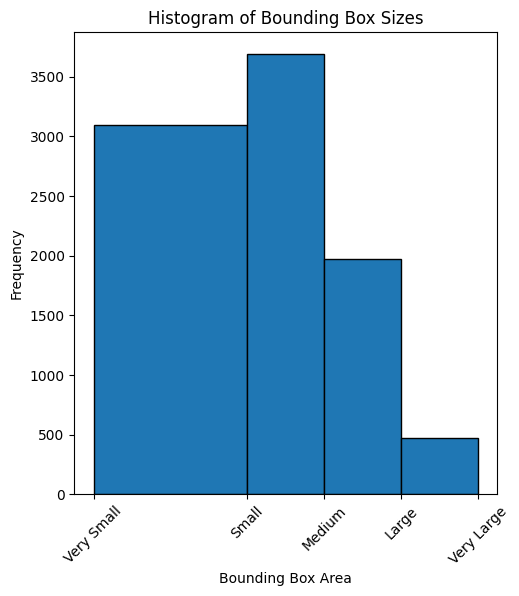

In [38]:
bounding_boxes = np.array(target_boxes_list[0])[:,3:]
bounding_boxes

areas = np.sqrt([width * height for (x_center, y_center, width, height) in bounding_boxes])

# Raggruppamento delle bounding box per dimensione
bins = [0, 0.1, 0.15, 0.2, 0.25]
labels = ['Very Small', 'Small', 'Medium', 'Large', 'Very Large']
box_sizes = np.digitize(areas, bins=bins, right=True)

# Creazione dell'istogramma delle dimensioni delle bounding box
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(areas, bins=bins, edgecolor='black')
plt.title('Histogram of Bounding Box Sizes')
plt.xlabel('Bounding Box Area')
plt.ylabel('Frequency')
plt.xticks(ticks=bins, labels=labels, rotation=45)


In [39]:
def calculate_iou(box1, box2):
    # box1 e box2 devono essere nella forma [x_center, y_center, width, height]
    x1_min = box1[0] - box1[2] / 2
    x1_max = box1[0] + box1[2] / 2
    y1_min = box1[1] - box1[3] / 2
    y1_max = box1[1] + box1[3] / 2
    
    x2_min = box2[0] - box2[2] / 2
    x2_max = box2[0] + box2[2] / 2
    y2_min = box2[1] - box2[3] / 2
    y2_max = box2[1] + box2[3] / 2
    
    # Calcolo delle coordinate dell'intersezione
    x_inter_min = max(x1_min, x2_min)
    x_inter_max = min(x1_max, x2_max)
    y_inter_min = max(y1_min, y2_min)
    y_inter_max = min(y1_max, y2_max)
    
    # Calcolo dell'area dell'intersezione
    inter_area = max(0, x_inter_max - x_inter_min) * max(0, y_inter_max - y_inter_min)
    
    # Calcolo dell'area delle due box
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)
    
    # Calcolo dell'area dell'unione
    union_area = box1_area + box2_area - inter_area
    
    # Calcolo dell'IoU
    iou = inter_area / union_area if union_area != 0 else 0
    return iou

def get_ious(predictions, real_boxes, bins, box_sizes):
    ious = []
    for idx_p, _, _, x_p, y_p, w_p, h_p in predictions:
        for idx_b, _, _, x_center, y_center, width, height in real_boxes:
            if idx_p == idx_b:
                pred_box = [x_p, y_p, w_p, h_p]
                real_box = [x_center, y_center, width, height]
                iou = calculate_iou(pred_box, real_box)
                ious.append(iou)

    # Calcolo della media dell'IoU per ciascun gruppo di dimensioni
    iou_means = []
    for i in range(len(bins) - 1):
        group_ious = [iou for iou, size in zip(ious, box_sizes) if size == i + 1]
        if group_ious:
            iou_means.append(np.mean(group_ious))
        else:
            iou_means.append(0)
    
    return iou_means

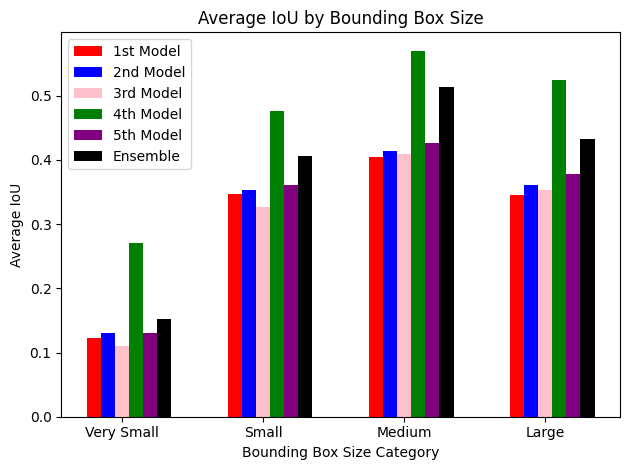

In [40]:
# Creiamo una lista di etichette per le categorie di dimensioni
labels = ['Very Small', 'Small', 'Medium', 'Large']

# Configuriamo il numero di gruppi e il numero di barre per gruppo
x = np.arange(len(labels))
width = 0.1  # Larghezza delle barre

fig, ax = plt.subplots()

# Aggiungiamo le barre per ogni set di distance_means
rects1 = ax.bar(x - 2 * width, get_ious(pred_boxes_list[0], target_boxes_list[0], bins, box_sizes), width, label='1st Model', color='red')
rects2 = ax.bar(x - 1 * width, get_ious(pred_boxes_list[1], target_boxes_list[0], bins, box_sizes), width, label='2nd Model', color='blue')
rects3 = ax.bar(x - 0 * width, get_ious(pred_boxes_list[2], target_boxes_list[0], bins, box_sizes), width, label='3rd Model', color='pink')
rects4 = ax.bar(x + 1 * width, get_ious(pred_boxes_list[3], target_boxes_list[0], bins, box_sizes), width, label='4th Model', color='green')
rects5 = ax.bar(x + 2 * width, get_ious(pred_boxes_list[4], target_boxes_list[0], bins, box_sizes), width, label='5th Model', color='purple')
rects6 = ax.bar(x + 3 * width, get_ious(ensembled_predictions, target_boxes_list[0], bins, box_sizes), width, label='Ensemble', color='black')

# Aggiungiamo le etichette, il titolo e la legenda
ax.set_xlabel('Bounding Box Size Category')
ax.set_ylabel('Average IoU')
ax.set_title('Average IoU by Bounding Box Size')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Aggiungiamo una disposizione più compatta
fig.tight_layout()

plt.show()

In [41]:
def get_distances(predictions, real_boxes):
    distances = []
    for idx_p, _ ,_ ,x_p, y_p, _ , _ in predictions:
        for idx_b,_, _ , x_center, y_center, width, height in real_boxes:
            if idx_p == idx_b:
                x_left = x_center - width / 2
                x_right = x_center + width / 2
                y_top = y_center - height / 2
                y_bottom = y_center + height / 2

                dist_left = abs(x_p - x_left) if x_p < x_left else float('inf')
                dist_right = abs(x_p - x_right) if x_p > x_right else float('inf')
                dist_top = abs(y_p - y_top) if y_p < y_top else float('inf')
                dist_bottom = abs(y_p - y_bottom) if y_p > y_bottom else float('inf')

                # Se il punto è all'interno della bounding box, la distanza è zero
                if x_left <= x_p <= x_right and y_top <= y_p <= y_bottom:
                    min_distance = 0
                else:
                    min_distance = min(dist_left, dist_right, dist_top, dist_bottom)

                distances.append(min_distance)

    # Calcolo della distanza media per ciascun gruppo di dimensioni
    distance_means = []
    for i in range(len(bins) - 1):
        group_distances = [dist for dist, size in zip(distances, box_sizes) if size == i + 1]
        if group_distances:
            distance_means.append(np.mean(group_distances))
        else:
            distance_means.append(0)
    
    return distance_means

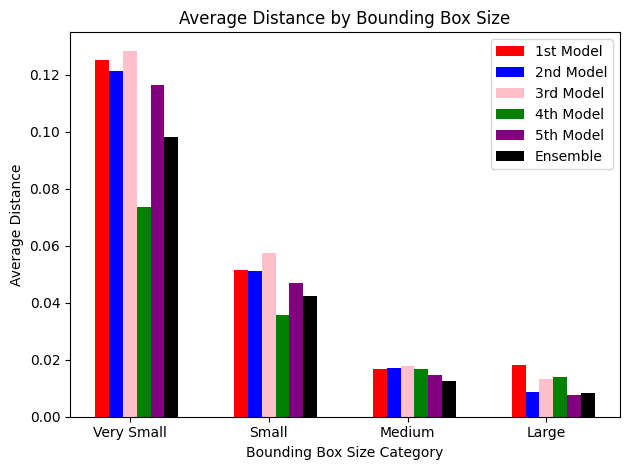

In [42]:
# Creiamo una lista di etichette per le categorie di dimensioni
labels = ['Very Small', 'Small', 'Medium', 'Large']

# Configuriamo il numero di gruppi e il numero di barre per gruppo
x = np.arange(len(labels))
width = 0.1  # Larghezza delle barre

fig, ax = plt.subplots()

# Aggiungiamo le barre per ogni set di distance_means
rects1 = ax.bar(x - 2 * width, get_distances(pred_boxes_list[0], target_boxes_list[0]), width, label='1st Model', color='red')
rects2 = ax.bar(x - 1 * width, get_distances(pred_boxes_list[1], target_boxes_list[0]), width, label='2nd Model', color='blue')
rects3 = ax.bar(x - 0 * width, get_distances(pred_boxes_list[2], target_boxes_list[0]), width, label='3rd Model', color='pink')
rects4 = ax.bar(x + 1 * width, get_distances(pred_boxes_list[3], target_boxes_list[0]), width, label='4th Model', color='green')
rects5 = ax.bar(x + 2 * width, get_distances(pred_boxes_list[4], target_boxes_list[0]), width, label='5th Model', color='purple')
rects6 = ax.bar(x + 3 * width, get_distances(ensembled_predictions, target_boxes_list[0]), width, label='Ensemble', color='black')

# Aggiungiamo le etichette, il titolo e la legenda
ax.set_xlabel('Bounding Box Size Category')
ax.set_ylabel('Average Distance')
ax.set_title('Average Distance by Bounding Box Size')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Aggiungiamo una disposizione più compatta
fig.tight_layout()

plt.show()